### This notebook shows how to access/view training set stored in the database (zarr files)

Before running this notebook (and all other notebooks that will use the 'utils.py' module), you would need to set the path to the data files as appropriate depending on whether you are working in SciServer or offline, and call the `init()` function to build the connection to the data files.

1. **On SciServer (run code cell #2)**
The path to the data files are hard coded in the `utils.py` module, you would only need to call the `init` function without any arguments.

2. **Offline (run code cell #3)**
The path to the directory hosting the data files needs to be provided by assigning the path string to variables `data_dir`, and then call the `init` function with the paths as the arguments, like `init(data_dir)`.

In [1]:
import pandas as pd
import numpy as np
import zarr
from utils import *
pd.set_option('display.max_columns', 999)

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 15

**1. Run the cell below to setup connection if working in SciServer**

In [2]:
# Run this cell if on SciServer
init()

**2. Run the cell below to setup connection if working offline**

In [2]:
# assign the data directory to data_dir
data_dir = 'path/to/training/data/directory'

# Initiate connection with data directory
init(data_dir)

## Quasars/AGNs
#### Note:
We start building the QSO catalog by selecting sources that are in the area of Stripe 82 from the SDSS DR7 Quasar catalog and the [DR14](https://www.sdss.org/dr14/algorithms/qso_catalog/) Quasar catalog separately, then find the union of these two samples to form the source catalog, which ends up containing ~27k objects. Next, we query the Stripe 82 database on CAS to retrive the multi-epoch PSF magnitudes and errors from [Stripe 82 DR7 Coadd](https://iopscience.iop.org/article/10.1088/0004-637X/794/2/120), including extinctions in all five bands. The exact query used is shown below:

```sql
select q.*, p.objid, p.psfmag_u, p.psfmag_g, p.psfmag_r, p.psfmag_i, p.psfmag_z,
  p.psfmagerr_u, p.psfmagerr_g, p.psfmagerr_r, p.psfmagerr_i, p.psfmagerr_z, p.extinction_u,
  p.extinction_g, p.extinction_r, p.extinction_i, p.extinction_z, b.distance
into mydb.qsoPhoto --ra, dec
from mydb.s82specqso as q
  cross apply fgetnearbyobjeq(q.ra, q.dec, 1/60.0) b
  join photoprimary as p on p.objid = b.objid
where ((p.flags & 0x10000000) != 0) 
  AND ((p.flags & 0x8100000c00a4) = 0) 
  AND (((p.flags & 0x400000000000) = 0) or (psfmagerr_g<=0.2))
  AND (((p.flags & 0x100000000000) = 0) or (p.flags & 0x1000) = 0)
  and (psfmagerr_g <= 1 and psfmagerr_r<= 1 and psfmagerr_i<=1 and psfmagerr_u<= 1 and psfmagerr_z<= 1)
  and (p.run = 106 or p.run = 206)
```

Lastly, we remove the objects don't have reliable detection in the Coadd. We are left with ~25k spectroscopically confirmed AGNs in the final catalog. Later, this catalog is matched to Gaia DR2 for proper motin and parallax measurments and SpIES for MIR detections.

**Missing data**   
All missing data in the catalog is marked using `NaN`.

### AGN master catalog

The full AGN catalog can be extracted with the `get_qso_cat()` convenience function.

In [3]:
qso_df = get_qso_cat()
qso_df.head()

,train_id,ra,dec,z,z_err,thing_id,specobjid,spec,sdss_objid,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,type,run,src2photo,dered_u,dered_g,dered_r,dered_i,dered_z,ra_sp,dec_sp,spies_id,flux_auto_ch1,fluxerr_auto_ch1,flux_auto_ch2,fluxerr_auto_ch2,class_star_ch1,class_star_ch2,src2spies,src2gaia,gaia_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,galex_id,fuv_mag,fuv_magerr,nuv_mag,nuv_magerr,src2galex,mpstype,stdColor[0],stdColor[1],stdColor[2],stdColor[3],psFlux[u],psFlux[g],psFlux[r],psFlux[i],psFlux[z],psPm[0],psPm[1],psParallax,lcN,class
0,0,310.0377,-1.005592,2.167268,0.000676,NaN,276352159556042752,7,8647475119809364088,0.008446,0.003265,0.003569,0.002969,0.005960,0.332155,0.244397,0.177257,0.134408,0.095297,6,206,0.083856,19.312095,18.875304,18.513243,18.263452,18.025003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.024083,4226318531605912576,0.225240,0.283972,-0.609215,0.464463,-0.206735,0.305267,6401869206833334272,NaN,NaN,23.184412,0.436260,1.696868,0.0,0.436792,0.362060,0.249792,0.238449,65942.328054,68419.255122,142798.907734,179737.984132,228014.565848,-0.609215,-0.206735,0.225240,55,qso
1,3,311.6088,0.393812,0.333015,0.000351,NaN,537282917827608576,7,8647475121420632840,0.011383,0.001996,0.001869,0.002298,0.003088,0.494767,0.364045,0.264036,0.200210,0.141952,3,206,0.051798,19.489293,18.512125,17.722814,17.683700,16.975958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.092993,4228017414511443968,-0.149525,0.160723,0.044235,0.275073,0.075344,0.179892,2468467513536552960,21.218325,0.061310,21.052940,0.047003,0.742009,0.0,0.977168,0.789311,0.039115,0.707741,56011.332155,58115.957521,295732.889174,306580.434350,599285.639829,0.044235,0.075344,-0.149525,63,qso
2,4,312.3636,0.718380,1.699121,0.000973,NaN,314071864353751040,7,8647475121957832451,0.037532,0.009041,0.007869,0.007637,0.022191,0.526905,0.387692,0.281186,0.213215,0.151172,3,206,0.154056,21.131835,20.595028,20.152444,19.718245,19.668558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218568,4228378535360380928,-0.486411,0.729782,-0.776679,2.051325,0.635052,1.033818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.536807,0.442585,0.434199,0.049687,12319.895839,12794.084912,31547.575429,47059.204593,50039.124902,-0.776679,0.635052,-0.486411,47,qso
3,5,312.4020,0.834625,0.475306,0.000354,NaN,314071864311808000,7,8647475121957831705,0.020328,0.005620,0.006083,0.007393,0.019640,0.520510,0.382986,0.277773,0.210627,0.149337,3,206,0.160105,20.403761,20.042354,19.884427,19.652183,19.501243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2468502697908636672,22.338091,0.160893,21.475634,0.056155,0.364936,0.0,0.361406,0.157927,0.232244,0.150940,24118.091101,25029.261444,40383.598908,50012.543099,58422.366330,NaN,NaN,NaN,108,qso
4,6,312.4340,0.455123,2.080289,0.001066,NaN,314353417491316736,7,8647474692461166737,0.013942,0.005312,0.006064,0.007587,0.019144,0.459490,0.338089,0.245210,0.185935,0.131831,6,106,0.150507,19.954390,20.005581,19.965770,19.760675,19.543730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.100156,4228358022596119040,0.250211,0.772921,1.965712,2.234255,-0.107082,1.024258,2468537882278632960,NaN,NaN,23.030893,0.171892,0.508715,0.0,-0.051192,0.039811,0.205095,0.216945,36491.532269,37865.005535,37467.915153,45254.921252,56170.337863,1.965712,-0.107082,0.250211,50,qso


#### Column definitions

`qso_cat_meta()` will display the column definitions.

In [4]:
qso_cat_meta()

{'class_star_ch1': 'SpIES 3.6 micrometer morphology classification, > 0.5 for resolved source',
 'class_star_ch2': 'SpIES 4.5 micrometer morphology classification, > 0.5 for resolved source',
 'dec': 'Source DEC from SDSS in degrees (J2000)',
 'dec_sp': 'DEC from SpIES in degrees (J2000)',
 'dered_{band}': 'Extinction corrected PSF mag (psfMag - extinction), replace band with u, g, r, i, z',
 'extinction_{band}': 'Galactic extinction in band, obtained using SDSS CasJobs, replace band with u, g, r, i, z',
 'flux_auto_ch1': 'SpIES 3.6 micrometer flux value automatically extracted using SExtractor',
 'flux_auto_ch2': 'SpIES 4.5 micrometer flux value automatically extracted using SExtractor',
 'fluxerr_auto_ch1': 'SpIES 3.6 micrometer flux error given by SExtractor',
 'fluxerr_auto_ch2': 'SpIES 4.5 micrometer flux error given by SExtractor',
 'fuv_mag': 'GALEX FUV mag',
 'fuv_magerr': 'Photometric error in GALEX FUV mag',
 'gaia_id': 'Gaia DR2 source id',
 'galex_id': 'GALEX ID for of matc

#### P.S.
We added a few more columns to best mimic the LSST data model, specifically **psPm[]**, **psParallax**, **psFlux[]** and **stdColor[]**. Detailed column definition can be obtain using function ``qso_cat_meta()``

### Get/Plot light curves

The light curves were downloaded from SDSS CAS using the following query:

```sql
select q.train_id, p.run, p.psfmag_u, p.psfmag_g, p.psfmag_r, p.psfmag_i, p.psfmag_z,
  p.psfmagerr_u, p.psfmagerr_g, p.psfmagerr_r, p.psfmagerr_i, p.psfmagerr_z, p.offsetRa_u, 
  p.offsetRa_g, p.offsetRa_i, p.offsetRa_z, p.offsetDec_u, p.offsetDec_g, p.offsetDec_i, 
  p.offsetDec_z, f.airmass_u, f.airmass_g, f.airmass_r, f.airmass_i, f.airmass_z, 
  LTRIM(STR(mjd_u,20,2)) as mjd_u,
  LTRIM(STR(mjd_g,20,2)) as mjd_g,
  LTRIM(STR(mjd_r,20,2)) as mjd_r,
  LTRIM(STR(mjd_i,20,2)) as mjd_i,
  LTRIM(STR(mjd_z,20,2)) as mjd_z
into mydb.s82qsoLC
from mydb.s82qsoFinal as q -- ra, dec
  cross apply fgetnearbyobjalleq(q.ra, q.dec, 1/60.0) b
  join photoobj as p on p.objid = b.objid --photoobj for both primary+secondary
  join field as f on f.fieldid = p.fieldid
where ((p.flags & 0x10000000) != 0) 
  AND ((p.flags & 0x8100000c00a4) = 0) 
  AND (((p.flags & 0x400000000000) = 0) or (p.psfmagerr_r <= 0.2))
  AND (((p.flags & 0x100000000000) = 0) or (p.flags & 0x1000) = 0)
  and (p.psfmagerr_g <= 1 and p.psfmagerr_r<= 1 and p.psfmagerr_i<=1 and p.psfmagerr_u<= 1 and p.psfmagerr_z<= 1)
  and (p.run !=106)
  and (p.run !=206)
  and f.quality in (2,3)
order by train_id
```

- To retrieve the light curve for any object, use functions ``get_sdss_qso()``.  It is necessary to provide the `train_id` as a required argument.  This is an integer index for each object in the catalog. One can convert `train_id` to SDSS run-rerun-camcol-field-obj `objID` using `train2sdss` and vice versa, using `sdss2train`.    
- To plot the light curves, use the function `plot_sdss_qso()` for original data, or use the function `plot_merge_gri()` for merged light curves that are normalized by mean or median of each band. 

**!!Note that not all integers are valid `train_id`s.**
For example, 0 is valid and 1 is not. To obtain a list of valid `train_id`s, you can use the function `valid_ids()` or look at the `train_id` column in the static catalog dataframe (returned by `get_qso_cat()`, `get_var_cat()` or `get_gal_cat`). Convenience functions in `utils.py` will check for the provided `train_id`, if not valid, an error will be thrown!

In [6]:
valid_ids().head()

,train_id,Type
0,0,qso
1,3,qso
2,4,qso
3,5,qso
4,6,qso


To see what arguments can be passed to each function, use the help method, `help(plot_sdss_lc)` for example.

In [7]:
help(plot_sdss_lc)

Help on function plot_sdss_lc in module utils:

plot_sdss_lc(train_id, bands=['u', 'g', 'r', 'i', 'z'], clip=True)
    Plot SDSS light curves without merging.
    
    Args:
        train_id (int): Unique ID for an object in training sample.
        bands (list): Optional, a list specifying light curves in which bands to plot.
        clip (bool): Optional, indicates whether to run filter removing outliers, default to True.
    
    Return:
        bands (list): A list specifying the band filters in which to plot the light curves.
        x (list): A list of numpy arrays of mjd for observations in each band.
        y (list): A list of numpy arrays of magnitude in each band (dered mags)
        err (list): A list of numpy arrays of magnitude errors in each band



The `plot_sdss_lc` function will return lists of arrays that can be used to make plots. Please use `help` to see the definition for each returned list. The size of each list will be determined by how many bands one wants to plot the light curves in. The argument `clip` specifies whether to clean up the light curves using a three point median filter.  The example below demonstrates how to make a plot using the returned values, where a clean light curve has been plotted on top of the orginal light curve. 

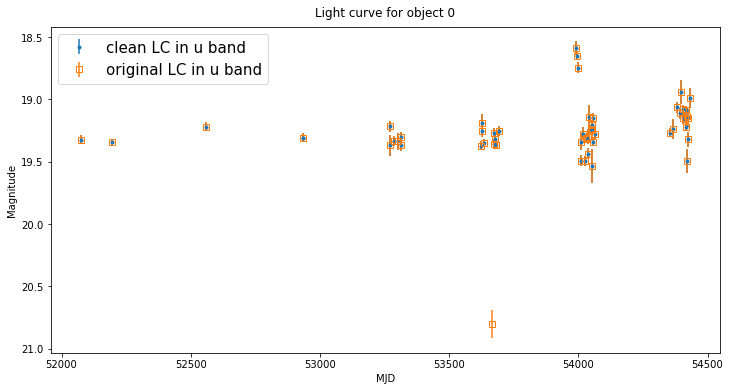

In [8]:
# plot light curves in the u band
fig = plt.figure(figsize=(12,6))
qso_train_id = 0
bands1, x1, y1, err1 = plot_sdss_lc(qso_train_id, bands=['u'])
bands2, x2, y2, err2 = plot_sdss_lc(qso_train_id, bands=['u'], clip=False) # return light curves with bad observations

for i in range(len(bands1)):
    plt.errorbar(x1[i], y1[i], err1[i], label='clean LC in {} band'.format(bands1[i]), fmt='.')
    plt.errorbar(x2[i], y2[i], err2[i], label='original LC in {} band'.format(bands2[i]),\
                 fmt='s', markerfacecolor='none')
plt.gca().invert_yaxis()
plt.title('Light curve for object {}'.format(0))
plt.xlabel('MJD')
plt.ylabel('Magnitude')
plt.legend(fontsize=15)

**Note:**  
From the plot above, we can see the flux in the original light curve suddenly drop around MJD=53650. We suspect that this is caused some kind of calibration failure, since such behavior is observed across many light curves and all occured around that time.  So, we implemented a method to remove artifacts by first applying a three-point median filter to the light curve, then removing outliers that deviate more than 0.5 mag from the median-filtered light curve.  Further cleaning beyond this demonstration is likely to needed for optimal use of the light curves. 

**Currently, we only normalize and merge light curve by subtracting the mean or median (can be specified while calling the plot function). More sphoiscated light curve merging methods should be implemented, for example, [CREAM](https://academic.oup.com/mnras/article/456/2/1960/1066664), but computing cost will need to be considered. For now, this should be okay to get started. Any comments/suggestions for better light curve merging methods are welcome.**

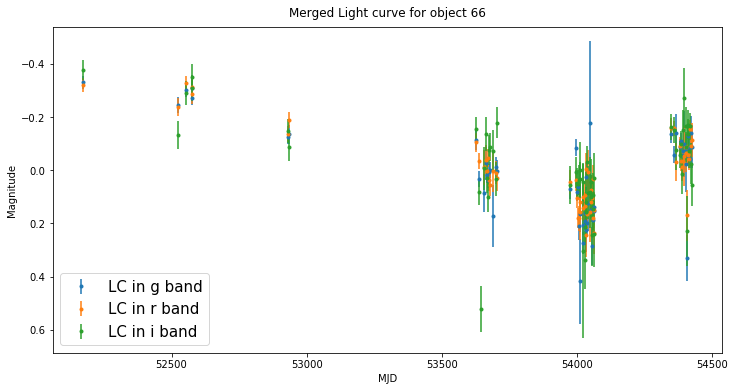

In [9]:
# merged lc using sdss g, r, i
# plot light curves in the u band
fig = plt.figure(figsize=(12,6))

bands1, x1, y1, err1 = plot_merged_lc(66, ['g', 'r', 'i'])

for i in range(len(bands1)):
    plt.errorbar(x1[i], y1[i], err1[i], label='LC in {} band'.format(bands1[i]), fmt='.')

plt.gca().invert_yaxis()
plt.title('Merged Light curve for object {}'.format(66))
plt.xlabel('MJD')
plt.ylabel('Magnitude')
plt.legend(fontsize=15)

#### Advanced Plots
One can use `get_sdss_qso` to place more strict cuts on the data or even implement your own outlier removal algorithm (set clip=False). The code below demonstrates how to make a light curve plot for the object 66, but request `psfmagerr_z < 0.2`.

In [10]:
# first get the light curve data
qso_66 = get_sdss_qso(66, clip=False)
qso_66.head(2)

,run,dered_u,dered_g,dered_r,dered_i,dered_z,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,offsetRa_u,offsetRa_g,offsetRa_i,offsetRa_z,offsetDec_u,offsetDec_g,offsetDec_i,offsetDec_z,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,mjd_u,mjd_g,mjd_r,mjd_i,mjd_z,datetime_u,datetime_g,datetime_r,datetime_i,datetime_z
0,2583,20.62062,20.25311,20.07562,20.01055,19.93927,0.091859,0.024581,0.025834,0.036817,0.111751,0.113656,0.000337,-0.018515,0.086513,-0.087452,-0.046524,-0.000911,0.115100,1.314003,1.320897,1.307316,1.310635,1.317423,52172.25,52172.25,52172.24,52172.25,52172.25,2001-09-20 06:00:00,2001-09-20 06:00:00,2001-09-20 05:45:36,2001-09-20 06:00:00,2001-09-20 06:00:00
1,3322,20.71124,20.33904,20.15907,20.25505,20.32638,0.130198,0.031520,0.034433,0.052413,0.176033,0.051332,-0.003377,0.038069,0.023391,0.070465,-0.027012,0.030464,-0.052493,1.177413,1.176714,1.178233,1.177808,1.177047,52522.20,52522.21,52522.20,52522.20,52522.20,2002-09-05 04:48:00,2002-09-05 05:02:24,2002-09-05 04:48:00,2002-09-05 04:48:00,2002-09-05 04:48:00


In [11]:
# apply custom cuts to the light curves
# require observations having psfmagerr_z < 0.2
x = qso_66.mjd_z[qso_66.psfmagerr_z < 0.2]
y = qso_66.dered_z[qso_66.psfmagerr_z < 0.2]
err = qso_66.psfmagerr_z[qso_66.psfmagerr_z < 0.2]

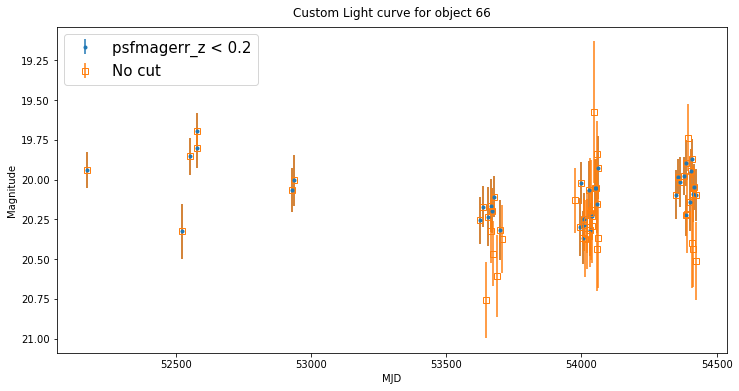

In [12]:
# make a custom LC plot
fig = plt.figure(figsize=(12,6))

plt.errorbar(x, y, err, fmt='.' , label='psfmagerr_z < 0.2')
plt.errorbar(qso_66.mjd_z, qso_66.dered_z, qso_66.psfmagerr_z, \
             fmt='s', markerfacecolor='none', label='No cut' )

plt.gca().invert_yaxis()
plt.title('Custom Light curve for object {}'.format(66))
plt.xlabel('MJD')
plt.ylabel('Magnitude')
plt.legend(fontsize=15, loc=2)

---
## 2. Non-AGN variables

### Note:
The non-AGN variables catalog consists of all objects in [Ivezic et al. 2007](http://faculty.washington.edu/ivezic/sdss/catalogs/S82variables.html)--except those have been spectroscopically identified as AGN. Thus we are **NOT** confident that all sources in this catalog are non-AGN. This catalog could contains AGNs that were missed by target selection algorithms in the first place.  

All SDSS light curves all queried directly from CAS using the following query:

```sql
select q.train_d, q.ivz_id, p.run, p.psfmag_u, p.psfmag_g, p.psfmag_r, p.psfmag_i, p.psfmag_z,
  p.psfmagerr_u, p.psfmagerr_g, p.psfmagerr_r, p.psfmagerr_i, p.psfmagerr_z, p.offsetRa_u, 
  p.offsetRa_g, p.offsetRa_i, p.offsetRa_z, p.offsetDec_u, p.offsetDec_g, p.offsetDec_i, 
  p.offsetDec_z, f.airmass_u, f.airmass_g, f.airmass_r, f.airmass_i, f.airmass_z, 
  LTRIM(STR(mjd_u,20,2)) as mjd_u,
  LTRIM(STR(mjd_g,20,2)) as mjd_g,
  LTRIM(STR(mjd_r,20,2)) as mjd_r,
  LTRIM(STR(mjd_i,20,2)) as mjd_i,
  LTRIM(STR(mjd_z,20,2)) as mjd_z
into mydb.vstarLC
from mydb.vstarFinal as q --catalog including ra, dec
  cross apply fgetnearbyobjalleq(q.ra, q.dec, 1/60.0) b
  -- join photoobj below to get both primary+secondary object
  join photoobj as p on p.objid = b.objid
  join field as f on f.fieldid = p.fieldid
where ((p.flags & 0x10000000) != 0) 
  AND ((p.flags & 0x8100000c00a4) = 0) 
  AND (((p.flags & 0x400000000000) = 0) or (p.psfmagerr_r <= 0.2))
  AND (((p.flags & 0x100000000000) = 0) or (p.flags & 0x1000) = 0)
  and (p.psfmagerr_g <= 1 and p.psfmagerr_r<= 1 and p.psfmagerr_i<=1 and p.psfmagerr_u<= 1 and p.psfmagerr_z<= 1)
  and (p.run !=106)
  and (p.run !=206)
  and f.quality in (2,3)
  and p.type = 6
order by train_d
```

### Non-AGN Variables master catalog

The full non-AGN catalog can be extracted with the `get_var_cat()` convenience function.

In [13]:
vstar_df = get_var_cat()
vstar_df.head()

,train_id,ivz_id,ra,dec,sdss_objid,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,type,specobjid,run,src2photo,dered_u,dered_g,dered_r,dered_i,dered_z,ra_sp,dec_sp,spies_id,flux_auto_ch1,fluxerr_auto_ch1,flux_auto_ch2,fluxerr_auto_ch2,class_star_ch1,class_star_ch2,src2spies,src2gaia,gaia_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,galex_id,fuv_mag,fuv_magerr,nuv_mag,nuv_magerr,src2galex,mpstype,stdColor[0],stdColor[1],stdColor[2],stdColor[3],psFlux[u],psFlux[g],psFlux[r],psFlux[i],psFlux[z],psPm[0],psPm[1],psParallax,lcN,class
0,100012,7906731,37.49921,1.248179,8647475122531991636,0.018714,0.003049,0.003790,0.005687,0.019610,0.125279,0.092179,0.066856,0.050695,0.035943,6,0,206,0.080803,20.872561,19.853071,19.798564,19.817875,19.853337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.080648,2501387338283191808,-1.088944,0.509479,-0.638340,1.135483,-1.290321,0.843259,3785207454586900992,NaN,NaN,22.384655,0.173528,0.940821,0.0,1.019490,0.054507,-0.019311,-0.035462,15652.252822,16248.984216,43707.649029,42931.448916,4.215728e+04,-0.638340,-1.290321,-1.088944,64,vStar
1,100016,7907235,337.49950,1.230992,8647475122505712198,0.033394,0.001987,0.000994,0.000829,0.001670,0.414332,0.304861,0.221111,0.167662,0.118874,6,0,206,0.060045,21.113058,18.763849,17.449119,16.766768,16.391656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.229563,2702582302420520960,1.326021,0.155768,16.476970,0.339029,-1.713997,0.261593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.349210,1.314730,0.682351,0.375113,12535.479466,13017.556004,380520.448083,713376.049325,1.026504e+06,16.476970,-1.713997,1.326021,62,vStar
2,100017,7907288,337.49980,-0.002995,8647475120895099460,0.031712,0.004624,0.003833,0.004397,0.014379,0.368637,0.271240,0.196725,0.149171,0.105764,6,0,206,0.019169,21.165513,20.076470,19.583955,19.429559,19.355206,337.499836,-0.002989,620326,14.699725,2.305519,14.990035,2.25308,0.269771,0.01114,0.130273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.089043,0.492516,0.154395,0.074353,11942.406820,12402.802438,53261.744502,61397.889774,6.686797e+04,NaN,NaN,NaN,113,vStar
3,100022,7907645,54.99949,0.323060,8647475121465917818,0.034498,0.003399,0.002651,0.002963,0.011062,0.529983,0.389956,0.282829,0.214460,0.152055,6,0,206,0.006514,21.110687,19.658324,19.128311,18.944389,18.871035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.122775,3263858760489510400,-0.542882,0.426956,5.368844,0.800095,-3.600950,0.834979,3786192617005388800,NaN,NaN,22.786367,0.277641,2.314083,0.0,1.452364,0.530013,0.183922,0.073355,12562.968675,13046.051447,81038.093326,95995.377008,1.045478e+05,5.368844,-3.600950,-0.542882,65,vStar
4,100024,7907773,312.50020,0.567557,8647474692461167243,0.011534,0.001593,0.001054,0.000989,0.001960,0.467870,0.344255,0.249682,0.189326,0.134235,6,0,106,0.060403,19.688180,17.853845,17.055088,16.679824,16.468735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.125541,4228372629781307392,0.676685,0.106288,0.782367,0.268649,-11.758659,0.156629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.834334,0.798758,0.375264,0.211088,46634.409166,48387.657921,547004.442348,772852.290396,9.561557e+05,0.782367,-11.758659,0.676685,60,vStar


#### Column definitions

In [14]:
var_cat_meta()

{'class_star_ch1': 'SpIES 3.6 micrometer morphology classification, > 0.5 for resolved source',
 'class_star_ch2': 'SpIES 4.5 micrometer morphology classification, > 0.5 for resolved source',
 'dec': 'Source DEC from SDSS in degrees (J2000)',
 'dec_sp': 'DEC from SpIES in degrees (J2000)',
 'dered_{band}': 'Extinction corrected PSF mag (psfMag - extinction), replace band with u, g, r, i, z',
 'extinction_{band}': 'Galactic extinction in band, obtained using SDSS CasJobs, replace band with u, g, r, i, z',
 'flux_auto_ch1': 'SpIES 3.6 micrometer flux value automatically extracted using SExtractor',
 'flux_auto_ch2': 'SpIES 4.5 micrometer flux value automatically extracted using SExtractor',
 'fluxerr_auto_ch1': 'SpIES 3.6 micrometer flux error given by SExtractor',
 'fluxerr_auto_ch2': 'SpIES 4.5 micrometer flux error given by SExtractor',
 'fuv_mag': 'GALEX FUV mag',
 'fuv_magerr': 'Photometric error in GALEX FUV mag',
 'gaia_id': 'Gaia DR2 source id',
 'galex_id': 'GALEX ID for of matc

#### P.S.
As above, we added a few more columns to best mimc the LSST data models, specifically **psPm[]**, **psParallax**, **psFlux[]** and **stdColor[]**. Detailed column definition can be obtain using function ``var_cat_meta()``

### Get/Plot light curves
- To retrieve the light curves, use the function `get_sdss_lc()` with `train_id` at the input.  
- To plot the light curves, use function `plot_sdss_lc()` or `plot_merged_lc()`.

The `train_id` for non-AGN variable starts at 100012. As for the QSO light curves, `clip` is set to `True` as the default.

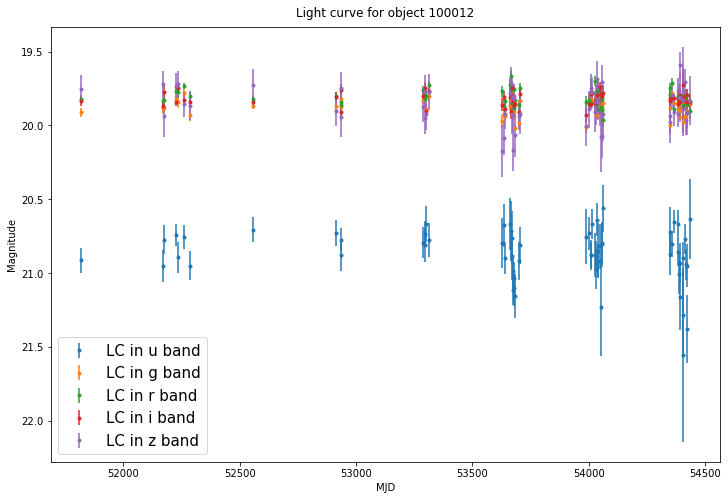

In [21]:
# plot var
fig = plt.figure(figsize=(12,8))
var_train_id = 100012
bands1, x1, y1, err1 = plot_sdss_lc(var_train_id)

for i in range(len(bands1)):
    plt.errorbar(x1[i], y1[i], err1[i], label='LC in {} band'.format(bands1[i]), fmt='.')

plt.gca().invert_yaxis()
plt.title('Light curve for object {}'.format(var_train_id))
plt.xlabel('MJD')
plt.ylabel('Magnitude')
plt.legend(fontsize=15)

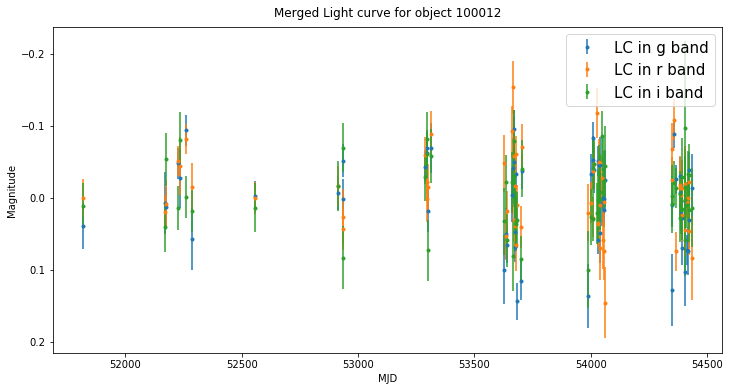

In [16]:
# plot gri merged light curve
fig = plt.figure(figsize=(12,6))

bands1, x1, y1, err1 = plot_merged_lc(var_train_id, ['g', 'r', 'i'])

for i in range(len(bands1)):
    plt.errorbar(x1[i], y1[i], err1[i], label='LC in {} band'.format(bands1[i]), fmt='.')

plt.gca().invert_yaxis()
plt.title('Merged Light curve for object {}'.format(var_train_id))
plt.xlabel('MJD')
plt.ylabel('Magnitude')
plt.legend(fontsize=15)

### Galaxy master catalog

Our training set also includes ~110k spectroscopically confirmed galaxies. Similar convenience functions as demonstrated for AGNs and non-AGN variables are also implemented for galaxies.

In [17]:
gal_df = get_gal_cat()
gal_df.head()

,train_id,specobjid,ra,dec,spec_subclass,z,z_err,sdss_objid,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,type,run,src2photo,dered_u,dered_g,dered_r,dered_i,dered_z,ra_sp,dec_sp,spies_id,flux_auto_ch1,fluxerr_auto_ch1,flux_auto_ch2,fluxerr_auto_ch2,class_star_ch1,class_star_ch2,src2spies,src2gaia,gaia_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,galex_id,fuv_mag,fuv_magerr,nuv_mag,nuv_magerr,src2galex,mpstype,stdColor[0],stdColor[1],stdColor[2],stdColor[3],psFlux[u],psFlux[g],psFlux[r],psFlux[i],psFlux[z],psPm[0],psPm[1],psParallax,lcN,class
0,1000001,417717971272624128,329.3018,-0.029728,nan,0.223353,0.000009,8658200491745280276,0.732331,0.025938,0.022803,0.025699,0.052780,0.319993,0.235448,0.170766,0.129487,0.091808,3,7033,0.014890,22.190957,19.317723,18.842344,18.497203,18.284252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2906618499158779392,21.825811,0.097285,20.829296,0.037987,0.689455,0.0,2.873235,0.475379,0.345141,0.212951,4600.436094,4804.496005,105458.423647,144922.606412,179566.159134,NaN,NaN,NaN,54,gal
1,1000003,417779818801686528,327.3609,-1.238340,nan,0.111303,0.000016,8658198493516595295,0.100511,0.018993,0.028228,0.021180,0.039859,0.455764,0.335347,0.243221,0.184427,0.130761,3,6568,0.012953,19.573056,18.150083,17.391689,17.083503,16.804859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2470367469627250176,NaN,NaN,22.516691,0.166822,2.949272,0.0,1.422973,0.758395,0.308186,0.278644,51851.933826,53800.672796,401190.145326,532874.030592,701578.319635,NaN,NaN,NaN,54,gal
2,1000004,417780643435407360,327.1570,-0.028400,nan,0.101933,0.000021,8658188255384699301,0.389678,0.028230,0.022020,0.021246,0.034876,0.756291,0.556472,0.403599,0.306037,0.216984,3,4184,0.006862,21.975659,19.867698,19.251701,18.553603,18.264096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.107961,0.615998,0.698098,0.289507,5630.023020,5867.071356,72331.969484,137586.356220,182932.466393,NaN,NaN,NaN,53,gal
3,1000005,417793562697033728,326.8968,-0.659120,nan,0.186024,0.000032,8658200156206268771,0.164926,0.028690,0.014010,0.020300,0.034648,0.365284,0.268772,0.194936,0.147814,0.104802,3,6955,0.058287,20.489316,19.238858,18.567454,17.893176,17.360878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6380063721222308864,NaN,NaN,21.467045,0.403453,2.036482,1.0,1.250458,0.671404,0.674278,0.532298,22288.979724,23132.002978,135843.949891,252786.027895,420394.207067,NaN,NaN,NaN,49,gal
4,1000007,417819126342379520,327.6124,1.221269,BROADLINE,0.119774,0.000021,8658201189140070541,0.378288,0.029482,0.017229,0.016318,0.021327,0.350600,0.257968,0.187100,0.141872,0.100589,3,7195,0.097147,20.411710,18.575292,17.647580,17.235548,16.879741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.836418,0.927712,0.412032,0.355807,23942.012249,24846.619137,316952.008468,463240.310892,654820.673795,NaN,NaN,NaN,63,gal


#### Column definitions

In [18]:
gal_cat_meta()

{'class_star_ch1': 'SpIES 3.6 micrometer morphology classification, > 0.5 for resolved source',
 'class_star_ch2': 'SpIES 4.5 micrometer morphology classification, > 0.5 for resolved source',
 'dec': 'Source DEC in degrees (J2000)',
 'dec_sp': 'DEC from SpIES in degrees (J2000)',
 'dered_{band}': 'Extinction corrected PSF mag (psfMag - extinction), replace band with u, g, r, i, z',
 'extinction_{band}': 'Galactic extinction in band, obtained using SDSS CasJobs, replace band with u, g, r, i, z',
 'flux_auto_ch1': 'SpIES 3.6 micrometer flux value automatically extracted using SExtractor',
 'flux_auto_ch2': 'SpIES 4.5 micrometer flux value automatically extracted using SExtractor',
 'fluxerr_auto_ch1': 'SpIES 3.6 micrometer flux error given by SExtractor',
 'fluxerr_auto_ch2': 'SpIES 4.5 micrometer flux error given by SExtractor',
 'fuv_mag': 'GALEX FUV mag',
 'fuv_magerr': 'Photometric error in GALEX FUV mag',
 'gaia_id': 'Gaia DR2 source id',
 'galex_id': 'GALEX ID for of matched detect

### Get/Plot light curves
- To retrieve the light curves, use the function `get_sdss_lc()` with `train_id` at the input.  
- To plot the light curves, use function `plot_sdss_lc()` or `plot_merged_lc()`.

The `train_id` for galaxies starts at 1000001. As for the QSO light curves, `clip` is set to `True` as the default.

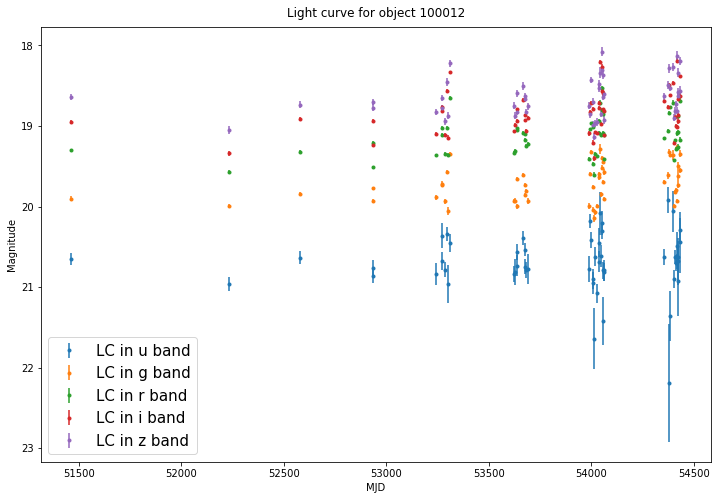

In [22]:
# plot var
fig = plt.figure(figsize=(12,8))
gal_train_id = 1000001
bands1, x1, y1, err1 = plot_sdss_lc(gal_train_id)

for i in range(len(bands1)):
    plt.errorbar(x1[i], y1[i], err1[i], label='LC in {} band'.format(bands1[i]), fmt='.')

plt.gca().invert_yaxis()
plt.title('Light curve for object {}'.format(var_train_id))
plt.xlabel('MJD')
plt.ylabel('Magnitude')
plt.legend(fontsize=15)

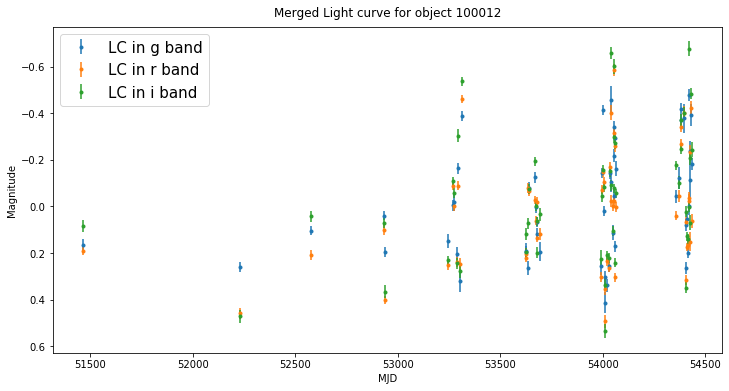

In [20]:
# plot gri merged light curve
fig = plt.figure(figsize=(12,6))

bands1, x1, y1, err1 = plot_merged_lc(gal_train_id, ['g', 'r', 'i'])

for i in range(len(bands1)):
    plt.errorbar(x1[i], y1[i], err1[i], label='LC in {} band'.format(bands1[i]), fmt='.')

plt.gca().invert_yaxis()
plt.title('Merged Light curve for object {}'.format(var_train_id))
plt.xlabel('MJD')
plt.ylabel('Magnitude')
plt.legend(fontsize=15)